In [1]:
import numpy as np
from scipy.stats import norm

import sbi.utils as utils
from sbi.utils.user_input_checks import check_sbi_inputs, process_prior, process_simulator
from sbi.inference import NPE, simulate_for_sbi

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
from plot_functions import *

# Inferring Galactic Parameters from Chemical Abundances with Simulation-Based Inference

![](plots/sbi2.png)

# Priors

In [2]:
# Elements to track
labels_out = ['C', 'Fe', 'H', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']

# Input parameters
labels_in = ['high_mass_slope', 'log10_N_0', 'log10_starformation_efficiency', 'log10_sfr_scale', 'outflow_feedback_fraction', 'time']
priors = torch.tensor([[-2.3000,  0.3000],
                       [-2.8900,  0.3000],
                       [-0.3000,  0.3000],
                       [ 0.5500,  0.1000],
                       [ 0.5000,  0.1000]])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)


# Model

Simple Neural Network to replace the simulator and create training data.

In [3]:
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels_in), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(labels_out))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

model = Model_Torch()

In [4]:
# --- Load the weights ---
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval();

# Train SBI

In [5]:
# ----- set up the simulator -----
def simulator(params):
    y = model(params)
    y = y.detach().numpy()

    # Remove H from data, because it is just used for normalization (output with index 2)
    y = np.delete(y, 2)

    return y

In [6]:
prior, num_parameters, prior_returns_numpy = process_prior(combined_priors)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [7]:
# ----- set up model -----
inference = NPE(prior=prior, show_progress_bars=True)

start = t.time()

# --- simulate the training data ---
print()
print("Simulating data...")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
print(f"Genereted {len(theta)} samples")

# --- add noise ---
pc_ab = 5 # observational error in abundance

x_err = np.ones_like(x)*float(pc_ab)/100.
x = norm.rvs(loc=x,scale=x_err)
x = torch.tensor(x).float()

# --- train ---
print()
print("Training the posterior...")
density_estimator = inference.append_simulations(theta, x).train()

# --- build the posterior ---
posterior = inference.build_posterior(density_estimator)

end = t.time()
comp_time = end - start

print()
print(f'Time taken to train the posterior with {len(theta)} samples: '
      f'{np.floor(comp_time/60).astype("int")}min {np.floor(comp_time%60).astype("int")}s')


Simulating data...


  0%|          | 0/10000 [00:00<?, ?it/s]

Genereted 10000 samples

Training the posterior...
 Neural network successfully converged after 154 epochs.
Time taken to train the posterior with 10000 samples: 3min 14s


# Simulate observations
Simulate the chemical abundances for the sampled stars using the simulator.

In [8]:
# Global parameters of galaxy
# high_mass_slope and log10_N_0
globalP = torch.tensor([[-2.3, -2.89]])

# Local parameters
# log10_starformation_efficiency, log10_sfr_scale, outflow_feedback_fraction, time
# independet parameters for each star in the galaxy
localP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [9]:
N_stars = 1000
simulations = 1000

# Create N_stars individual stars for the galaxy
stars = localP.sample((N_stars,))
stars = torch.cat((globalP.repeat(N_stars, 1), stars), dim=1)

In [10]:
# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)  

# Remove H from data, because it is just used for normalization (output with index 2)
abundances = torch.cat([abundances[:,0:2], abundances[:,3:]], axis=1)
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 1000 stars: 0.030 s


In [11]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

# Inference
Use the mock observations to infer the Galactic parameters.

In [14]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 100

start = t.time()
for i in range(len(abundances)):
    x = add_noise(abundances[i].detach().numpy())
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_obs.append(alpha)
    log10_N_Ia_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_obs = np.array(alpha_IMF_obs).ravel()
log10_N_Ia_obs = np.array(log10_N_Ia_obs).ravel()

Time to run 100 simulations for 1000 stars: 9.534 s


# Plot

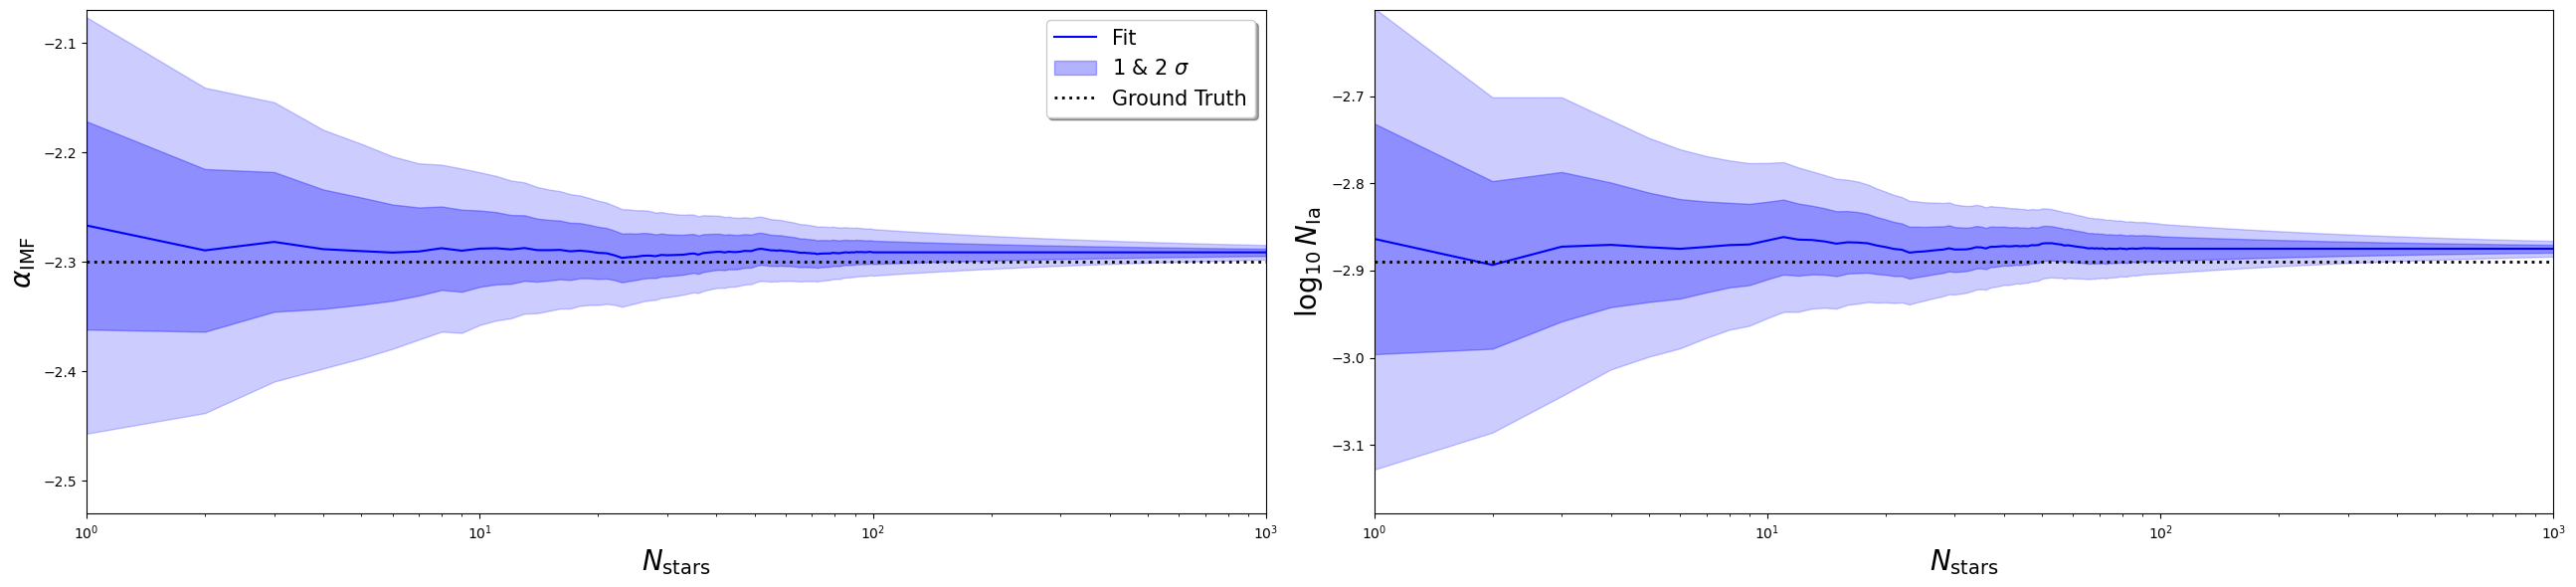

In [15]:
stars = np.arange(1,1000)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, globalP[0], stars)

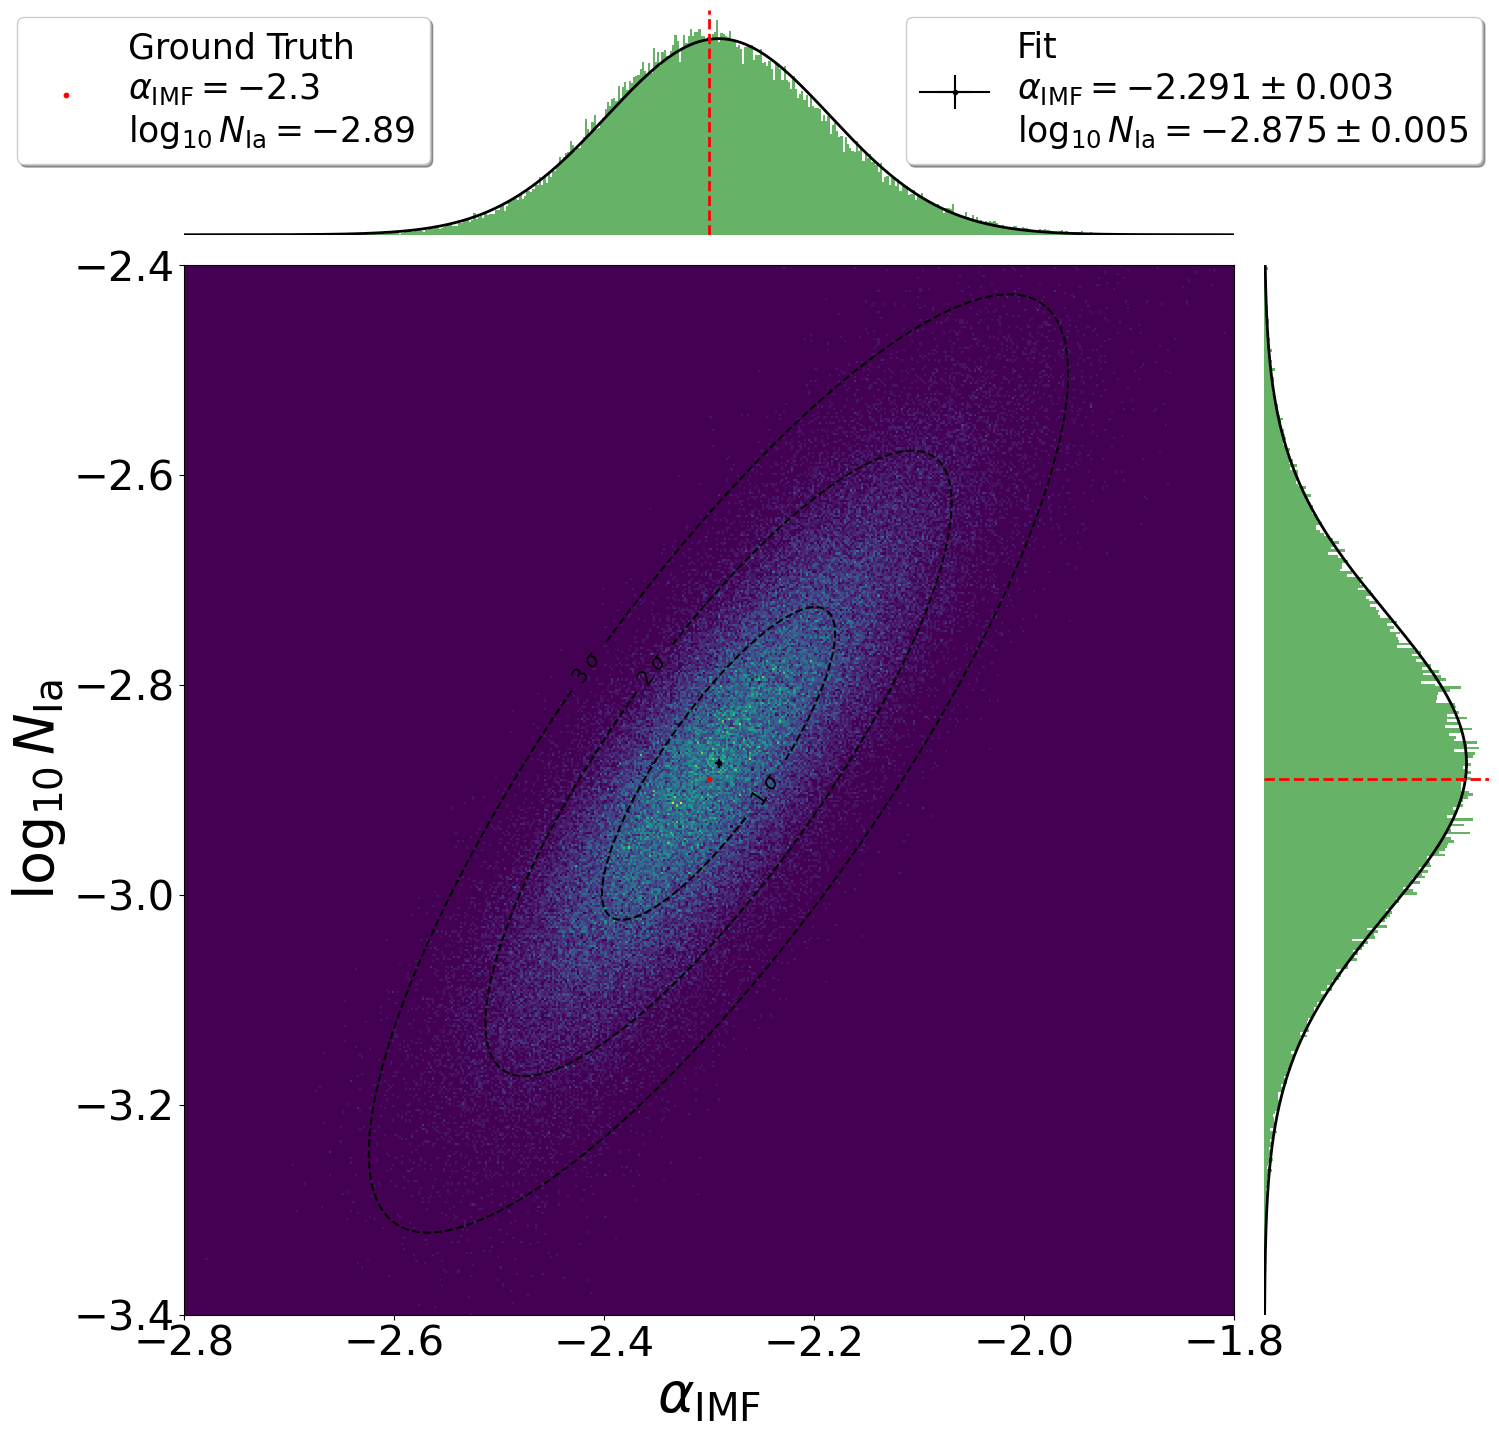

In [16]:
plot_2d_hist_sides(alpha_IMF_obs, log10_N_Ia_obs, globalP[0], N_stars)